In [7]:
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from joblib import load
from utils import stat_test, boxplot_MSK, get_severity, plot_bucketed_probabilities

In [2]:
sheets_xlsx_raw = ['Injury']
datasheet_file_raw = 'data/R21_dataset_jul62023.xlsx'
df_raw = pd.read_excel(f'{datasheet_file_raw}', sheet_name=sheets_xlsx_raw, index_col=0)

In [3]:
# Load training sets for WoE and mean transformations
X_train_WOE = pd.read_csv('data/X_train_WOE.csv',index_col=0)
X_train_mean = pd.read_csv('data/X_train_mean.csv',index_col=0) 
y_train = pd.read_csv('data/y_train.csv',index_col=['ID']).squeeze()

In [4]:
# Load training sets for WoE and mean transformations
X_test_WOE = pd.read_csv('data/X_test_WOE.csv',index_col=0)
X_test_mean = pd.read_csv('data/X_test_mean.csv',index_col=0) 
y_test = pd.read_csv('data/y_test.csv',index_col=['ID']).squeeze()

In [5]:
# Load pipelines
pipeline_WOE = load('models/pipeline_WOE.joblib')
pipeline_mean = load('models/pipeline_MEAN.joblib')

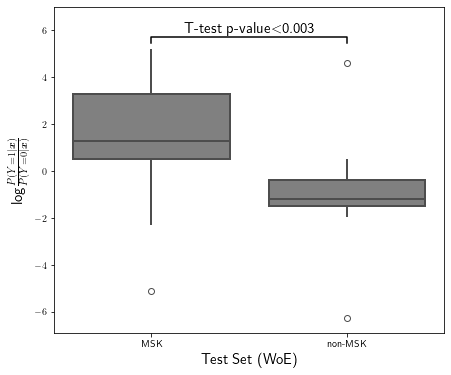

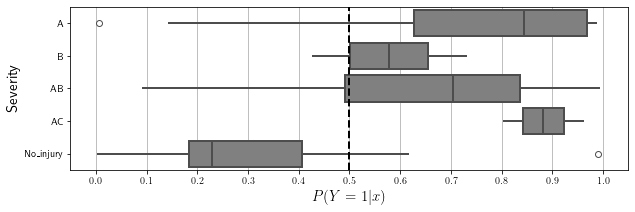

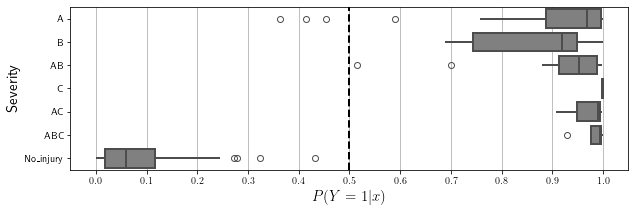

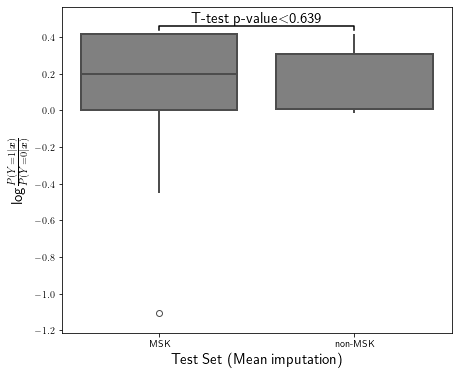

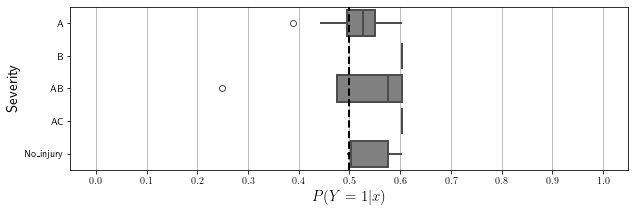

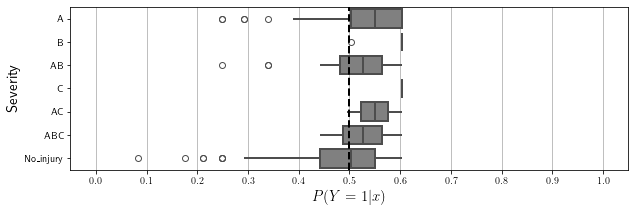

In [6]:
y_train_ = y_train.astype(int)
y_test_ = y_test.astype(int)
for j,data_name in enumerate(['WOE','MEAN']):
    if data_name=='WOE':
        X_train_ = X_train_WOE
        X_test_ = X_test_WOE
        pm = pipeline_WOE
        name_label = '(WoE)'
    elif data_name=='MEAN':
        X_train_ = X_train_mean
        X_test_ = X_test_mean
        pm = pipeline_mean
        name_label = '(Mean imputation)'

    df_lr_scores = pd.DataFrame({'description':['test accuracy','test f1-score','test precision','test recall','n_predictors'],
                                'score':[pm.score(X_test_,y_test_),metrics.f1_score(y_test_,pm.predict(X_test_)),
                                            metrics.precision_score(y_test_,pm.predict(X_test_)), 
                                            metrics.recall_score(y_test_,pm.predict(X_test_)),
                                            len(list(pm[0].get_feature_names_out()))]}).sort_values(by=['description'])
    stats_test = stat_test(pm[:-1].transform(X_test_),y_test_.reset_index(drop=True),pm[-1].coef_.T,pm[-1].intercept_)
    
    box_plot_fig = boxplot_MSK(pm[:-1].transform(X_test_), y_test_.astype(bool).reset_index(drop=True), pm[-1].coef_.T, pm[-1].intercept_, 
                               stats_test['p-val']['T-test'],label=f'Test Set {name_label}')
    
    predictions_severity_test = get_severity(df_raw,X_test_,y_test_.astype(bool),pm)
    bucketed_probs_test_fig  = plot_bucketed_probabilities(predictions_severity_test, plot_type='boxplot', alpha=0.5)
    
    predictions_severity_train = get_severity(df_raw,X_train_,y_train_.astype(bool),pm)
    bucketed_probs_train_fig = plot_bucketed_probabilities(predictions_severity_train, plot_type='boxplot', alpha=0.5)
    

In [9]:
color = {'WOE':'blue','MEAN':'orange'}
linestyle = {'WOE':'--','MEAN':':'}

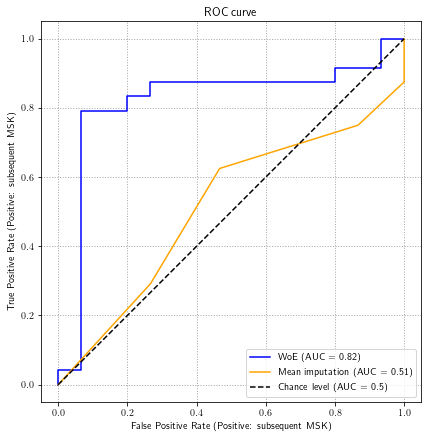

In [10]:
fig, ax = plt.subplots(figsize=(7,7))
roc_lr_woe = metrics.RocCurveDisplay.from_estimator(pipeline_WOE, X_test_WOE, y_test_, name='WoE', drop_intermediate=True, color=color['WOE'], ax=ax)
roc_lr_mean = metrics.RocCurveDisplay.from_estimator(pipeline_mean, X_test_mean, y_test_, name='Mean imputation', drop_intermediate=True, color=color['MEAN'], plot_chance_level=True, ax=roc_lr_woe.ax_)
ax.set_title("ROC curve")
ax.set_xlabel("False Positive Rate (Positive: subsequent MSK)")
ax.set_ylabel("True Positive Rate (Positive: subsequent MSK)")
ax.set_aspect('equal')
ax.grid(color='gray', linestyle=':', linewidth=1, alpha=0.7)

Text(0, 0.5, 'Precision (Positive: subsequent MSK)')

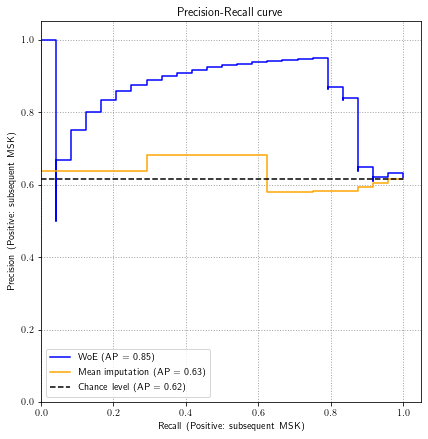

In [15]:
fig, ax = plt.subplots(figsize=(7,7))
pr_lr_woe = metrics.PrecisionRecallDisplay.from_estimator(pipeline_WOE, X_test_WOE, y_test, name='WoE', drop_intermediate=True, color=color['WOE'], plot_chance_level=False, ax=ax)
pr_lr_mean = metrics.PrecisionRecallDisplay.from_estimator(pipeline_mean, X_test_mean, y_test, name='Mean imputation', drop_intermediate=True, color=color['MEAN'], plot_chance_level=True, ax=pr_lr_woe.ax_)
ax.set_title("Precision-Recall curve")
ax.set_xlim(0.0,1.05)
ax.set_ylim(0.0,1.05)
ax.set_title("Precision-Recall curve")
ax.set_aspect('equal')
ax.grid(color='gray', linestyle=':', linewidth=1, alpha=0.7)
ax.set_xlabel("Recall (Positive: subsequent MSK)")
ax.set_ylabel("Precision (Positive: subsequent MSK)")
